In [230]:
# necessary imports
# Pandas to read in the CSV file and create the data frame
import pandas as pd
# NumPy for some basic mathematical functions
import numpy as np
from numpy import sort
# Xgboost for optimized distributed gradient boosting
from xgboost import XGBClassifier, plot_tree
# scikit-learn for simple and efficient tools for data mining and data analysis
from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedShuffleSplit,
cross_val_score, cross_val_predict, StratifiedKFold, KFold)
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, make_scorer, 
precision_recall_curve, recall_score, precision_score,f1_score, matthews_corrcoef,
brier_score_loss)
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
# Imblearn for imbalanced-learn package
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
# matplotlib : Python 2D plotting library
import matplotlib.pyplot as plt
# seaborn : Python data visualization library based on matplotlib
import seaborn as sns

/home/sylvain/miniconda3/lib/python3.7/multiprocessing/semaphore_tracker.py:55: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '
/home/sylvain/miniconda3/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# load data
df = pd.read_csv('Base_ptf.csv', engine='python',sep=';',parse_dates=['date'],index_col=['date'])

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.shape

(5245689, 34)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5245689 entries, 2011-03-31 to 2019-01-31
Data columns (total 34 columns):
sou_id               int64
prd_id               object
num                  int64
dt_inv               object
tmg                  float64
vac_euro_net         float64
vac_euro_brut        float64
vac_uc               float64
dt_origine           object
dt_effet             object
sexe                 object
dt_naissance         object
DAT_INV              float64
ARRETE               object
sortant              float64
chp_sortant          float64
arb_sortant          float64
entrant              float64
chp_entrant          float64
arb_entrant          float64
Pos                  object
capres               float64
nb_support           float64
age                  float64
lib_age              object
anciennete           float64
lib_anciennete       object
anciennete_em        float64
lib_anciennete_em    object
taux_uc              float64
lib_euro         

In [6]:
df_subset=pd.DataFrame(df[df.index.year==2018])
type(df_subset)

pandas.core.frame.DataFrame

In [7]:
print(df_subset.index.min())
print(df_subset.index.max())
print(df_subset.shape)

2018-01-31 00:00:00
2018-12-31 00:00:00
(794729, 34)


In [8]:
df_subset.arb.value_counts()

 0    793219
 1      1189
-1       321
Name: arb, dtype: int64

In [9]:
# Recoder la variable arbitrage
df_subset['arb']=df_subset['arb'].eq(1).astype('int')
df_subset.arb.value_counts()

0    793540
1      1189
Name: arb, dtype: int64

In [10]:
# List categorical variables
df_subset.describe(include='object')
# d: dictionary {old:new}
d = {'M': 1, 'F': 2}
df_subset['sexe'] = df_subset['sexe'].map(d)
df_subset['sexe'] = df_subset['sexe'].astype(float)

In [11]:
df_subset['age'].fillna((df_subset['age'].mean()), inplace=True)
df_subset['anciennete'].fillna((df_subset['anciennete'].mean()), inplace=True)
df_subset['anciennete_em'].fillna((df_subset['anciennete_em'].mean()), inplace=True)
df_subset['taux_uc'].fillna(0, inplace=True)
df_subset['capres'].fillna(0, inplace=True)
df_subset.isnull().sum()
# mark zero values as missing or NaN
#X = X.replace(0, np.NaN)
# fill missing values with mean column values
#X.fillna(X.mean(), inplace=True)
# count the number of NaN values in each column
#print(X.isnull().sum())

sou_id                    0
prd_id                    0
num                       0
dt_inv                    0
tmg                       0
vac_euro_net              0
vac_euro_brut             0
vac_uc                    0
dt_origine           672297
dt_effet                  3
sexe                      0
dt_naissance             10
DAT_INV              794729
ARRETE               793219
sortant              793219
chp_sortant          793219
arb_sortant          793219
entrant              793219
chp_entrant          793219
arb_entrant          793219
Pos                  646901
capres                    0
nb_support                0
age                       0
lib_age                   0
anciennete                0
lib_anciennete            0
anciennete_em             0
lib_anciennete_em         0
taux_uc                   0
lib_euro                  0
lib_total                 0
lib_capres                0
arb                       0
dtype: int64

Class 0: 793540
Class 1: 1189
Proportion: 667.4 : 1


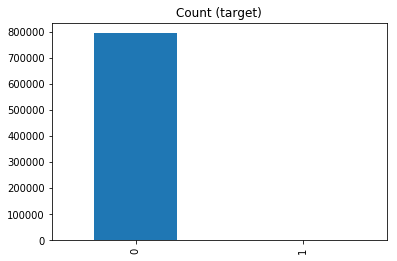

In [12]:
# Imbalanced datasets
target_count = df_subset.arb.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

In [121]:
# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [14]:
X.describe()

,sexe,age,anciennete,anciennete_em,taux_uc,vac_euro_net,capres
count,794729.000000,794729.000000,794729.000000,794729.000000,794729.000000,7.947290e+05,7.947290e+05
mean,1.652911,67.350950,7.077673,5.867625,0.145344,2.326614e+04,6.505586e+03
std,0.476045,18.490632,5.543388,3.739483,0.262956,4.317846e+04,1.673165e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-3.325340e-12
25%,1.000000,56.000000,3.000000,3.000000,0.000000,7.126800e+02,0.000000e+00
50%,2.000000,75.000000,6.000000,6.000000,0.000000,7.213650e+03,0.000000e+00
75%,2.000000,80.000000,10.000000,9.000000,0.214601,2.816440e+04,0.000000e+00
max,2.000000,105.000000,30.000000,17.000000,1.000000,1.264357e+06,3.285635e+05


In [122]:
# count the number of NaN values in each column
print(X.isnull().sum())

sexe             0
age              0
anciennete       0
anciennete_em    0
taux_uc          0
vac_euro_net     0
capres           0
dtype: int64


In [212]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)

# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return
 
get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

532468 total examples in y_train
class 0: 531664 examples, 99.85%
class 1: 804 examples, 0.15%

262261 total examples in y_test
class 0: 261876 examples, 99.85%
class 1: 385 examples, 0.15%



In [213]:
# Normalize the data
#scaler = StandardScaler().fit(X_train)
#X_train_sdt = scaler.transform(X_train)

#scaler = StandardScaler().fit(X_test)
#X_test_sdt = scaler.transform(X_test)

ss = StandardScaler()
X_train_sdt = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_sdt = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

print(X_train_sdt.shape)
print(type(X_train_sdt))
print(X_test_sdt.shape)
print(type(X_test_sdt))

(532468, 7)
<class 'pandas.core.frame.DataFrame'>
(262261, 7)
<class 'pandas.core.frame.DataFrame'>


In [211]:
print(y_train.value_counts())
print(y_test.value_counts())

0    531664
1       804
Name: arb, dtype: int64
0    261876
1       385
Name: arb, dtype: int64


In [189]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train_sdt, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test_sdt)

# Checking accuracy
print("Accuracy: %.2f%%" % (accuracy_score(y_test, lr_pred) * 100.0))
print('')
print('Confusion Matrix')
confusion_matrix(y_test, lr_pred)

Accuracy: 99.85%

Confusion Matrix


array([[261876,      0],
       [   385,      0]])

In [190]:
# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train_sdt, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test_sdt)

print("Accuracy: %.2f%%" % (accuracy_score(y_test, rfc_pred) * 100.0))
print('Confusion Matrix')
confusion_matrix(y_test, rfc_pred)

Accuracy: 99.84%
Confusion Matrix


array([[261846,     30],
       [   385,      0]])

In [191]:
xgb = XGBClassifier()
# train model
xgb.fit(X_train_sdt, y_train)
# predict on test set
xgb_pred = xgb.predict(X_test_sdt)

print("Accuracy: %.2f%%" % (accuracy_score(y_test, xgb_pred) * 100.0))
print('Confusion Matrix')
confusion_matrix(y_test, xgb_pred)

Accuracy: 99.85%
Confusion Matrix


array([[261876,      0],
       [   385,      0]])

In [192]:
model = XGBClassifier()
model.fit(X_train_sdt[['age']], y_train)
y_pred = model.predict(X_test_sdt[['age']])

print("Accuracy: %.2f%%" % (accuracy_score(y_test, xgb_pred) * 100.0))
print('Confusion Matrix')
confusion_matrix(y_test, xgb_pred)

Accuracy: 99.85%
Confusion Matrix


array([[261876,      0],
       [   385,      0]])

Confusion matrix:
 [[261876      0]
 [   385      0]]


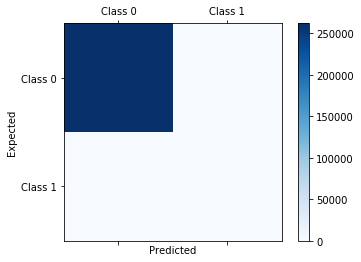

In [140]:
# Confusion matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [234]:
def model_resampling(model, X, y, resampling, calibrate, k=5, random_state=42, print_res = True):
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Define the cross-validation parameters
    # Common values of k are 5 and 10, as these have been shown experimentally to produce the best results
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create lists to save results to
    mcc = []
    brier = []
    actual_goals = []
    pred_goals = []
    accuracy = []
    f1 = []
    recall = []
    model_name = model.__class__.__name__
    
    # Create training and test data using cross validation and fit model for each fold
    for ii, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if resampling == None:
            res = 'no'
        else:
            X_train, y_train = resampling.fit_resample(X_train, y_train)
            res = resampling.__class__.__name__
        
        # Normalize the data
        ss = StandardScaler()
        X_train_sdt = ss.fit_transform(X_train)
        X_valid_sdt = ss.fit_transform(X_valid)

        # Calibrate model if necessary
        if calibrate == None:
            calibrated_probs = 'uncalibrated probabilities'
            model.fit(X_train_sdt, y_train)
        else:
            model = CalibratedClassifierCV(model, cv=2, method=calibrate)
            model.fit(X_train_sdt, y_train)
            calibrated_probs = '%s calibration' % calibrate
            
        y_pred = model.predict(X_valid_sdt)
        y_pred_proba = model.predict_proba(X_valid_sdt)[:,1]
 
        # Calculate mcc score, brier_loss and sum of predicted goal probabilities
        actual_goals.append(sum(y_valid))
        pred_goals.append(sum(y_pred_proba))
        mcc.append(matthews_corrcoef(y_valid, y_pred))
        brier.append(brier_score_loss(y_valid, y_pred_proba))
        f1.append(f1_score(y_valid, y_pred))
        recall.append(recall_score(y_valid, y_pred))
        accuracy.append(accuracy_score(y_valid, y_pred))
        
        # Save the results to a dataframe
    check = pd.DataFrame()
    check['mcc'] = mcc
    check['brier_loss'] = brier
    check['actual_goals'] = actual_goals
    check['predicted_goals'] = pred_goals
    check['goals_diff'] = abs(check['actual_goals'] - check['predicted_goals'])
    check['f1'] = f1
    check['recall'] = recall
    check['accuracy'] = accuracy
    
    # Print a summary of the results if required
    if print_res == True:
        print('Method: %s with %s resampling and %s'
              % (model_name, res, calibrated_probs))
        print('Goals:', '{0:.2f}'.format(check['actual_goals'].mean()))
        print('Predicted Goals:', '{0:.2f}'.format(check['predicted_goals'].mean()))
        print('MCC:', '{0:.3f}'.format(check['mcc'].mean()))
        print('Brier Loss:', '{0:.3f}'.format(check['brier_loss'].mean()))
        print('F1_score:', '{:.2%}'.format(check['f1'].mean()))
        print('Recall_score:', '{:.2%}'.format(check['recall'].mean()))
        print('Accuracy:', '{:.2%}'.format(check['accuracy'].mean()))
        print('')
    else: pass
 
    return check

In [221]:
# Try different re-sampling methods with a RandomForestClassifier
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit
 
tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(random_state=42)
smote_enn = SMOTEENN(random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
 
models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', rf, None, None))
models.append(('SMOTE', rf, smote, None))
models.append(('Tomek', rf, tomek, None))
models.append(('ENN', rf, enn, None))
models.append(('SMOTETomek', rf, smote_tomek, None))
models.append(('SMOTEENN', rf, smote_enn, None))
 
results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = model_resampling(model, X, y, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 300.90
MCC: 0.003
Brier Loss: 0.002
F1_score: 0.16%
Recall_score: 0.08%
Accuracy: 99.84%

Method: RandomForestClassifier with SMOTE resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 132270.41
MCC: -0.000
Brier Loss: 0.744
F1_score: 0.30%
Recall_score: 86.55%
Accuracy: 13.11%

Method: RandomForestClassifier with TomekLinks resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 295.30
MCC: 0.002
Brier Loss: 0.002
F1_score: 0.15%
Recall_score: 0.08%
Accuracy: 99.84%

Method: RandomForestClassifier with EditedNearestNeighbours resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 394.59
MCC: 0.006
Brier Loss: 0.002
F1_score: 0.43%
Recall_score: 0.25%
Accuracy: 99.83%

Method: RandomForestClassifier with SMOTETomek resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 131890.82
MCC: -0.001
Brier Loss: 0

In [222]:
# Define a function to plot barplot comparisons of models
def barplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')
 
    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)
     
    # Plot bars
    sns.barplot(x=x, y=y1, data=df, palette='muted', ax=axs[0])
    sns.barplot(x=x, y=y2, data=df, palette='muted', ax=axs[1])
 
    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
     
    return

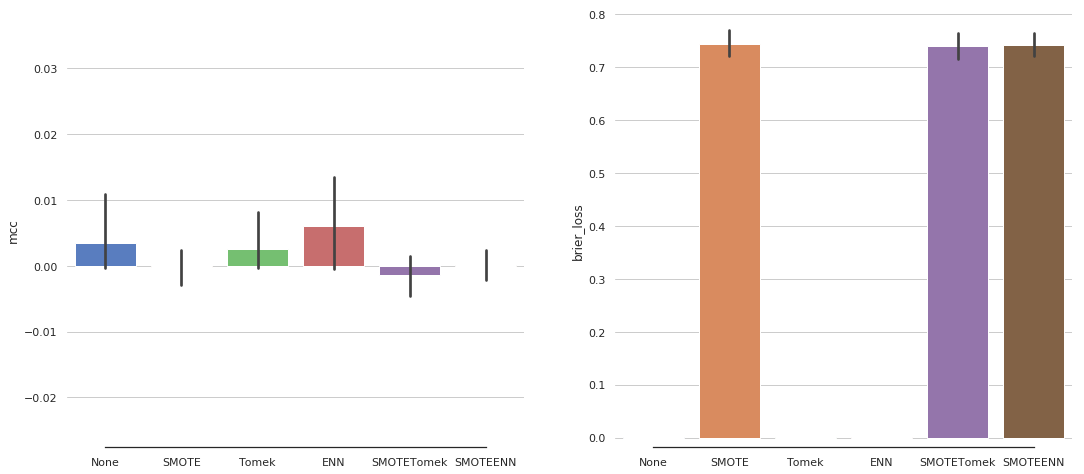

In [231]:
# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

Method: RandomForestClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 83809.58
MCC: 0.015
Brier Loss: 0.313
F1_score: 0.41%
Recall_score: 74.43%
Accuracy: 45.23%

Method: BalancedRandomForestClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 86474.94
MCC: 0.014
Brier Loss: 0.319
F1_score: 0.39%
Recall_score: 77.80%
Accuracy: 39.93%

Method: AdaBoostClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 79559.19
MCC: 0.016
Brier Loss: 0.251
F1_score: 0.39%
Recall_score: 83.86%
Accuracy: 35.85%

Method: XGBClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 85425.46
MCC: 0.017
Brier Loss: 0.309
F1_score: 0.41%
Recall_score: 82.51%
Accuracy: 39.21%



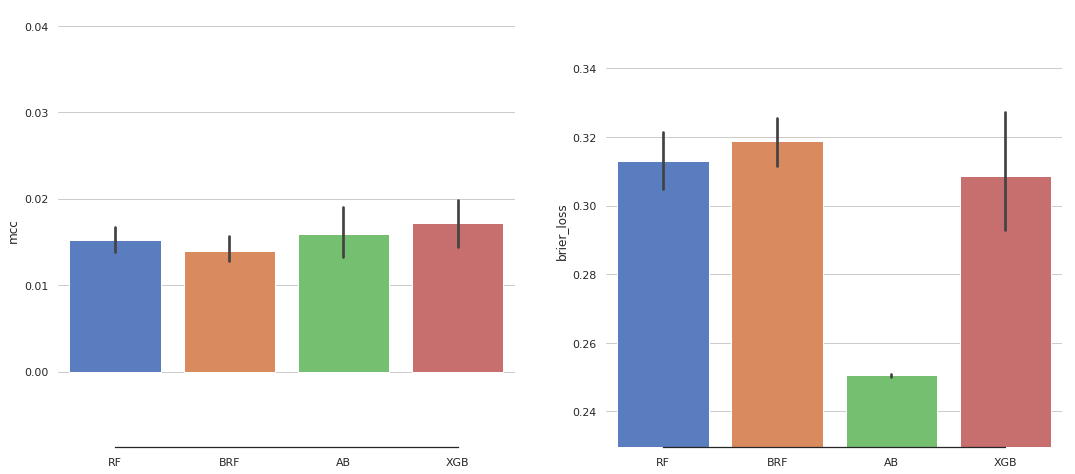

In [249]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)
rus = RandomUnderSampler(random_state=42)

models = []
models.append(('RF', rf, rus, None))
models.append(('BRF', brf, rus, None))
models.append(('AB', ab, rus, None))
models.append(('XGB', xgb, rus, None))
 
results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = model_resampling(model, X, y, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)
     
barplot_comparison(results_df)

In [ ]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)
ros = RandomOverSampler(random_state=42)

models = []
models.append(('RF', rf, ros, None))
models.append(('BRF', brf, ros, None))
models.append(('AB', ab, ros, None))
models.append(('XGB', xgb, ros, None))
 
results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = model_resampling(model, X, y, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)
     
barplot_comparison(results_df)

Method: RandomForestClassifier with RandomOverSampler resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 1112.83
MCC: 0.002
Brier Loss: 0.002
F1_score: 0.15%
Recall_score: 0.08%
Accuracy: 99.83%



In [85]:
# Models used for comparing resampling methods
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(nthread=-1,random_state=42)

Random under-sampling:
1    1189
0    1189
Name: arb, dtype: int64


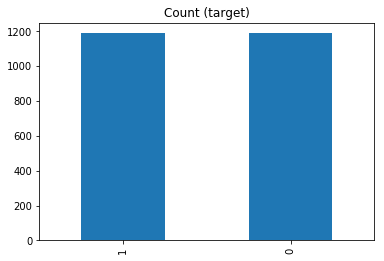

In [143]:
# Resampling

# Class count
count_class_0, count_class_1 = df_subset.arb.value_counts()

# Divide by class
df_class_0 = df_subset[df_subset['arb'] == 0]
df_class_1 = df_subset[df_subset['arb'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.arb.value_counts())

df_test_under.arb.value_counts().plot(kind='bar', title='Count (target)');

# split data into train and test sets
X = df_test_under[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']]
y = df_test_under.arb

In [150]:
test_resampling(brf, X, y, 'Random under-sampling')

Method: BalancedRandomForestClassifier with Random under-sampling resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 238.58
MCC: 0.255
Brier Loss: 0.227
F1_score: 63.66%
Recall_score: 65.52%
Accuracy: 62.66%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.241832,0.228406,238,248.638701,10.638701,0.644401,0.689076,0.619748
1,0.218222,0.232487,238,258.126913,20.126913,0.641075,0.701681,0.607143
2,0.296174,0.218594,238,214.482159,23.517841,0.625000,0.588235,0.647059
3,0.256323,0.229263,238,233.743294,4.256706,0.630480,0.634454,0.628151
4,0.262129,0.228608,237,237.885151,0.885151,0.642127,0.662447,0.630802


In [151]:
test_resampling(ab, X, y, 'Random under-sampling')

Method: AdaBoostClassifier with Random under-sampling resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 235.66
MCC: 0.260
Brier Loss: 0.247
F1_score: 66.36%
Recall_score: 75.36%
Accuracy: 62.07%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.209913,0.249225,238,237.872111,0.127889,0.649446,0.739496,0.600840
1,0.239040,0.250007,238,239.073767,1.073767,0.692668,0.932773,0.586134
2,0.361664,0.247487,238,235.948318,2.051682,0.673820,0.659664,0.680672
3,0.268908,0.240139,238,228.012295,9.987705,0.634454,0.634454,0.634454
4,0.221069,0.248973,237,237.392703,0.392703,0.667838,0.801688,0.601266


In [152]:
test_resampling(xgb, X, y, 'Random under-sampling')

Method: XGBClassifier with Random under-sampling resampling and uncalibrated probabilities
Goals: 237.80
Predicted Goals: 242.96
MCC: 0.285
Brier Loss: 0.231
F1_score: 67.39%
Recall_score: 75.62%
Accuracy: 63.58%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.240832,0.231956,238,256.934145,18.934145,0.662983,0.756303,0.615546
1,0.269468,0.234897,238,283.654481,45.654481,0.692568,0.861345,0.617647
2,0.336241,0.233759,238,191.662520,46.337480,0.663830,0.655462,0.668067
3,0.286728,0.228231,238,216.701569,21.298431,0.657258,0.684874,0.642857
4,0.291367,0.227709,237,265.832212,28.832212,0.692718,0.822785,0.635021


Random over-sampling:
1    793540
0    793540
Name: arb, dtype: int64


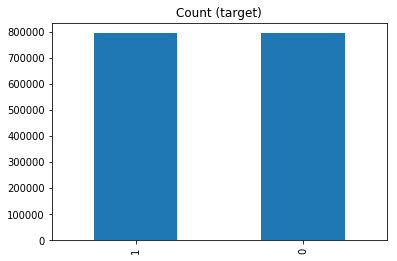

In [154]:
# Random over-sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.arb.value_counts())

df_test_over.arb.value_counts().plot(kind='bar', title='Count (target)');

# split data into train and test sets
X = df_test_over[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']]
y = df_test_over.arb

In [155]:
test_resampling(brf, X, y, 'Random over-sampling')

Method: BalancedRandomForestClassifier with Random over-sampling resampling and uncalibrated probabilities
Goals: 158708.00
Predicted Goals: 82851.32
MCC: 0.621
Brier Loss: 0.161
F1_score: 71.16%
Recall_score: 55.85%
Accuracy: 77.85%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.706747,0.127223,158708,93180.461795,65527.538205,0.800979,0.669248,0.833710
1,0.699442,0.136064,158708,93176.867499,65531.132501,0.794536,0.660471,0.829205
2,0.560005,0.188988,158708,73256.938686,85451.061314,0.648357,0.480360,0.739471
3,0.533438,0.178589,158708,73555.495062,85152.504938,0.615606,0.445113,0.722065
4,0.603902,0.172818,158708,81086.833998,77621.166002,0.698474,0.537503,0.767964


In [156]:
test_resampling(ab, X, y, 'Random over-sampling')

Method: AdaBoostClassifier with Random over-sampling resampling and uncalibrated probabilities
Goals: 158708.00
Predicted Goals: 158561.03
MCC: 0.329
Brier Loss: 0.249
F1_score: 68.22%
Recall_score: 72.35%
Accuracy: 66.30%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.334742,0.248798,158708,158551.660781,156.339219,0.685558,0.728023,0.666082
1,0.343194,0.249063,158708,158681.187117,26.812883,0.688663,0.729031,0.670414
2,0.310666,0.249175,158708,158718.931059,10.931059,0.680416,0.738709,0.653036
3,0.325165,0.248804,158708,158561.563076,146.436924,0.676506,0.707009,0.661920
4,0.328875,0.248408,158708,158291.789618,416.210382,0.679927,0.714658,0.663577


In [157]:
test_resampling(xgb, X, y, 'Random over-sampling')

Method: XGBClassifier with Random over-sampling resampling and uncalibrated probabilities
Goals: 158708.00
Predicted Goals: 155901.18
MCC: 0.364
Brier Loss: 0.206
F1_score: 69.75%
Recall_score: 73.63%
Accuracy: 68.08%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.366420,0.204992,158708,154112.333925,4595.666075,0.698823,0.737688,0.682073
1,0.367842,0.204911,158708,161733.618330,3025.618330,0.701230,0.745274,0.682464
2,0.368190,0.204984,158708,161230.407027,2522.407027,0.700711,0.742722,0.682766
3,0.363829,0.204443,158708,153833.742868,4874.257132,0.696773,0.733208,0.680917
4,0.352772,0.210837,158708,148595.788574,10112.211426,0.690211,0.722768,0.675599


In [98]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

RandomUnderSampler(random_state=None, ratio=None, replacement=False,
          return_indices=True, sampling_strategy='auto')
Removed indexes: [493005 212052 462784 ... 531565 532177 532367]


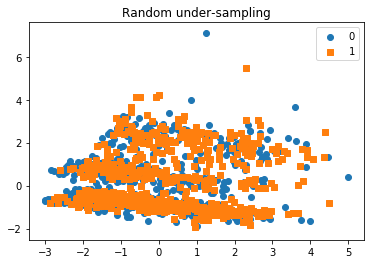

In [158]:
# Random under-sampling and over-sampling with imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_std = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

rus = RandomUnderSampler(return_indices=True)
print(rus)
X_rus, y_rus, id_rus = rus.fit_sample(X_train_std, y_train)
X_rus = pd.DataFrame(X_rus, columns = X_train_std.columns)

print('Removed indexes:', id_rus)

pca = PCA(n_components=2)
X_rus_pca = pca.fit_transform(ss.fit_transform(X_rus))
plot_2d_space(X_rus_pca, y_rus, 'Random under-sampling')

In [159]:
test_resampling(brf, X_rus, y_rus, 'RandomUnderSampler')

Method: BalancedRandomForestClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 158.81
MCC: 0.236
Brier Loss: 0.237
F1_score: 61.70%
Recall_score: 61.95%
Accuracy: 61.69%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.242255,0.239926,161,157.007850,3.992150,0.623457,0.627329,0.621118
1,0.174483,0.248572,161,167.127771,6.127771,0.602985,0.627329,0.586957
2,0.243441,0.234856,161,154.049050,6.950950,0.601307,0.571429,0.621118
3,0.297129,0.227022,161,139.645837,21.354163,0.609589,0.552795,0.645963
4,0.224179,0.233951,160,176.222534,16.222534,0.647887,0.718750,0.609375


In [160]:
test_resampling(ab, X_rus, y_rus, 'RandomUnderSampler')

Method: AdaBoostClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 159.96
MCC: 0.219
Brier Loss: 0.249
F1_score: 63.53%
Recall_score: 68.80%
Accuracy: 60.63%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.231608,0.247823,161,158.102006,2.897994,0.637427,0.677019,0.614907
1,0.123635,0.250158,161,161.367780,0.367780,0.616216,0.708075,0.559006
2,0.273424,0.248307,161,160.396063,0.603937,0.630915,0.621118,0.636646
3,0.279849,0.247971,161,159.784581,1.215419,0.630573,0.614907,0.639752
4,0.184662,0.250285,160,160.170720,0.170720,0.661616,0.818750,0.581250


In [161]:
test_resampling(xgb, X_rus, y_rus, 'RandomUnderSampler')

Method: XGBClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 152.98
MCC: 0.221
Brier Loss: 0.246
F1_score: 60.60%
Recall_score: 62.83%
Accuracy: 60.57%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.235116,0.250002,161,137.980274,23.019726,0.569444,0.509317,0.614907
1,0.116490,0.256710,161,189.053743,28.053743,0.630769,0.763975,0.552795
2,0.323037,0.234831,161,140.333765,20.666235,0.658307,0.652174,0.661491
3,0.179772,0.256191,161,117.092612,43.907388,0.492424,0.403727,0.583851
4,0.251573,0.232940,160,180.428066,20.428066,0.678851,0.812500,0.615625


530860 new random picked points


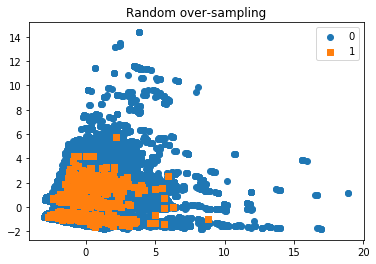

In [162]:
from imblearn.over_sampling import RandomOverSampler

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_sdt = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_sdt = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train_sdt, y_train)
X_ros = pd.DataFrame(X_ros, columns = X_train_sdt.columns)

print(X_ros.shape[0] - X_train_sdt.shape[0], 'new random picked points')

pca = PCA(n_components=2)
X_ros_pca = pca.fit_transform(X_ros)
plot_2d_space(X_ros_pca, y_ros, 'Random over-sampling')

In [163]:
test_resampling(brf, X_ros, y_ros, 'RandomOverSampler')

Method: BalancedRandomForestClassifier with RandomUnderSampler resampling and uncalibrated probabilities
Goals: 106332.80
Predicted Goals: 56974.55
MCC: 0.638
Brier Loss: 0.152
F1_score: 72.92%
Recall_score: 57.95%
Accuracy: 78.92%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.681851,0.140365,106333,59985.219331,46347.780669,0.777612,0.636961,0.817836
1,0.624140,0.149033,106333,55315.212125,51017.787875,0.719353,0.562149,0.780684
2,0.725109,0.124366,106333,66054.187154,40278.812846,0.816763,0.691084,0.844959
3,0.522294,0.194578,106333,46898.707457,59434.292543,0.601257,0.430158,0.714726
4,0.634828,0.151632,106332,56619.405738,49712.594262,0.731208,0.577126,0.787848


In [164]:
test_resampling(ab, X_ros, y_ros, 'RandomOverSampler')

Method: AdaBoostClassifier with RandomOverSampler resampling and uncalibrated probabilities
Goals: 106332.80
Predicted Goals: 106252.95
MCC: 0.339
Brier Loss: 0.249
F1_score: 68.40%
Recall_score: 71.71%
Accuracy: 66.88%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.336614,0.249125,106333,106336.583320,3.583320,0.686590,0.729538,0.666985
1,0.343063,0.248969,106333,106286.483121,46.516879,0.685951,0.719212,0.670723
2,0.334515,0.248723,106333,106190.335293,142.664707,0.681219,0.712573,0.666548
3,0.333411,0.248673,106333,106161.072446,171.927554,0.677903,0.702388,0.666270
4,0.348267,0.248980,106332,106290.266520,41.733480,0.688399,0.721721,0.673316


In [165]:
test_resampling(xgb, X_ros, y_ros, 'RandomOverSampler')

Method: XGBClassifier with RandomOverSampler resampling and uncalibrated probabilities
Goals: 106332.80
Predicted Goals: 105022.04
MCC: 0.378
Brier Loss: 0.202
F1_score: 70.40%
Recall_score: 74.29%
Accuracy: 68.78%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.388607,0.202912,106333,108591.811484,2258.811484,0.712035,0.760319,0.692508
1,0.382822,0.200842,106333,106301.614796,31.385204,0.707003,0.747698,0.690139
2,0.362440,0.203072,106333,101927.637701,4405.362299,0.693977,0.724498,0.680518
3,0.369076,0.204156,106333,101712.719191,4620.280809,0.698462,0.732783,0.683645
4,0.386723,0.199673,106332,106576.400826,244.400826,0.708752,0.749295,0.692092


Removed indexes: [     0      1      2 ... 532465 532466 532467]
532468 total examples in y_train
class 0: 531664 examples, 99.85%
class 1: 804 examples, 0.15%

None
532231 total examples in y_tl
class 0: 531427 examples, 99.85%
class 1: 804 examples, 0.15%

None


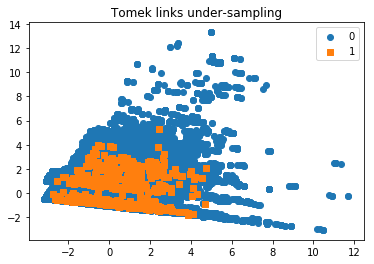

In [166]:
# Under-sampling: Tomek links
from imblearn.under_sampling import TomekLinks

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_std = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X_train_std, y_train)
X_tl = pd.DataFrame(X_tl, columns = X_train_std.columns)

print('Removed indexes:', id_tl)
print(get_class_dist(data=y_train, name='y_train'))
print(get_class_dist(data=y_tl, name='y_tl'))

pca = PCA(n_components=2)
X_tl_pca = pca.fit_transform(X_tl)
plot_2d_space(X_tl_pca, y_tl, 'Tomek links under-sampling')

In [167]:
test_resampling(brf, X_tl, y_tl, 'Tomek links under-sampling')

Method: BalancedRandomForestClassifier with Tomek links under-sampling resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 47576.77
MCC: 0.020
Brier Loss: 0.231
F1_score: 0.49%
Recall_score: 66.29%
Accuracy: 59.39%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.017241,0.218979,161,45359.499002,45198.499002,0.004674,0.608696,0.607936
1,0.021814,0.224852,161,46690.868215,46529.868215,0.005121,0.664596,0.609411
2,0.021497,0.235280,161,48459.971024,48298.971024,0.005005,0.683230,0.589125
3,0.020473,0.242912,161,49712.068825,49551.068825,0.004843,0.689441,0.571482
4,0.020503,0.230580,160,47661.423270,47501.423270,0.004898,0.668750,0.591564


In [168]:
test_resampling(ab, X_tl, y_tl, 'Tomek links under-sampling')

/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value enco

Method: AdaBoostClassifier with Tomek links under-sampling resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 51163.32
MCC: -0.000
Brier Loss: 0.231
F1_score: 0.00%
Recall_score: 0.00%
Accuracy: 99.82%



/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,-0.001377,0.226426,161,50603.521697,50442.521697,0.0,0.0,0.997238
1,0.000000,0.230990,161,51144.113953,50983.113953,0.0,0.0,0.998488
2,0.000000,0.232989,161,51370.398650,51209.398650,0.0,0.0,0.998487
3,0.000000,0.233446,161,51423.802023,51262.802023,0.0,0.0,0.998487
4,0.000000,0.232152,160,51274.757511,51114.757511,0.0,0.0,0.998497


In [169]:
test_resampling(xgb, X_tl, y_tl, 'Tomek links under-sampling')

/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value enco

Method: XGBClassifier with Tomek links under-sampling resampling and uncalibrated probabilities
Goals: 160.80
Predicted Goals: 164.09
MCC: 0.000
Brier Loss: 0.002
F1_score: 0.00%
Recall_score: 0.00%
Accuracy: 99.85%



/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.0,0.001509,161,155.640667,5.359333,0.0,0.0,0.998488
1,0.0,0.001509,161,155.430080,5.569920,0.0,0.0,0.998488
2,0.0,0.001509,161,167.674231,6.674231,0.0,0.0,0.998487
3,0.0,0.001510,161,182.284433,21.284433,0.0,0.0,0.998487
4,0.0,0.001500,160,159.397032,0.602968,0.0,0.0,0.998497


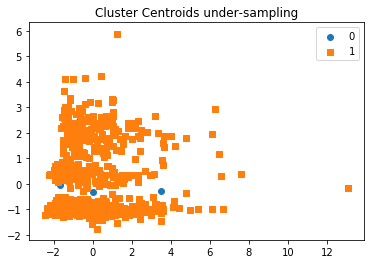

Accuracy: 0.15%


In [531]:
# Under-sampling: Cluster Centroids
from imblearn.under_sampling import ClusterCentroids

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_sdt = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_sdt = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

cc = ClusterCentroids(ratio={0: 10})
X_cc, y_cc = cc.fit_sample(X_train_sdt, y_train)
X_cc = pd.DataFrame(X_cc, columns = X_train_sdt.columns)

pca = PCA(n_components=2)
X_cc_pca = pca.fit_transform(X_cc)
plot_2d_space(X_cc_pca, y_cc, 'Cluster Centroids under-sampling')

model = XGBClassifier()
model.fit(X_cc, y_cc)
y_pred = model.predict(X_test_sdt)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

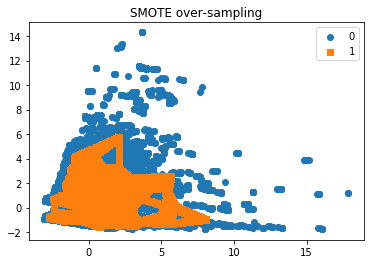

In [170]:
# Over-sampling: SMOTE
from imblearn.over_sampling import SMOTE

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_sdt = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_sdt = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train_sdt, y_train)
X_sm = pd.DataFrame(X_sm, columns = X_train_sdt.columns)

pca = PCA(n_components=2)
X_sm_pca = pca.fit_transform(X_sm)
plot_2d_space(X_sm_pca, y_sm, 'SMOTE over-sampling')

In [171]:
test_resampling(brf, X_sm, y_sm, 'SMOTE over-sampling')

Method: BalancedRandomForestClassifier with SMOTE over-sampling resampling and uncalibrated probabilities
Goals: 106332.80
Predicted Goals: 141084.52
MCC: 0.569
Brier Loss: 0.161
F1_score: 80.05%
Recall_score: 96.98%
Accuracy: 75.78%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.669481,0.130265,106333,148012.972783,41679.972783,0.840297,0.997545,0.810412
1,0.566047,0.168061,106333,132934.668247,26601.668247,0.799416,0.960896,0.758899
2,0.515395,0.181540,106333,149391.971339,43058.971339,0.778092,0.977965,0.721088
3,0.555257,0.157854,106333,140875.063748,34542.063748,0.795316,0.955837,0.754004
4,0.540390,0.166551,106332,134207.941099,27875.941099,0.789348,0.956984,0.744611


In [ ]:
test_resampling(ab, X_sm, y_sm, 'SMOTE over-sampling')

In [ ]:
test_resampling(xgb, X_sm, y_sm, 'SMOTE over-sampling')

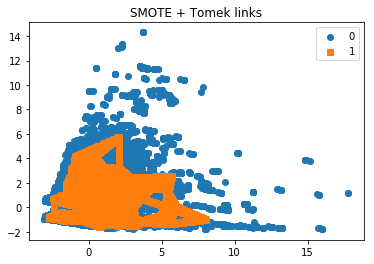

In [175]:
# Over-sampling followed by under-sampling
from imblearn.combine import SMOTETomek

# split data into X and y
X = pd.DataFrame(df_subset[['sexe','age','anciennete','anciennete_em','taux_uc','vac_euro_net','capres']])
y = df_subset.arb

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Normalize the data
X_train_sdt = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_sdt = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X_train_sdt, y_train)
X_smt = pd.DataFrame(X_smt, columns = X_train_sdt.columns)

pca = PCA(n_components=2)
X_smt_pca = pca.fit_transform(X_smt)
plot_2d_space(X_smt_pca, y_smt, 'SMOTE + Tomek links')

In [176]:
test_resampling(brf, X_smt, y_smt, 'SMOTE + Tomek links')

Method: BalancedRandomForestClassifier with SMOTE + Tomek links resampling and uncalibrated probabilities
Goals: 106232.80
Predicted Goals: 139583.33
MCC: 0.584
Brier Loss: 0.157
F1_score: 80.57%
Recall_score: 97.31%
Accuracy: 76.52%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.526387,0.177398,106233,148043.746831,41810.746831,0.782454,0.976825,0.728413
1,0.602470,0.154424,106233,137445.766500,31212.766500,0.812136,0.988506,0.771338
2,0.557182,0.165390,106233,127143.289531,20910.289531,0.796511,0.924562,0.763798
3,0.650943,0.129063,106233,147954.046691,41721.046691,0.832070,0.997148,0.798754
4,0.583577,0.156433,106232,137329.819347,31097.819347,0.805306,0.978330,0.763475


In [177]:
test_resampling(ab, X_smt, y_smt, 'SMOTE + Tomek links')

Method: AdaBoostClassifier with SMOTE + Tomek links resampling and uncalibrated probabilities
Goals: 106232.80
Predicted Goals: 106746.41
MCC: 0.326
Brier Loss: 0.248
F1_score: 71.58%
Recall_score: 93.77%
Accuracy: 62.72%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.290226,0.248699,106233,107014.728825,781.728825,0.706121,0.972193,0.595385
1,0.317503,0.248569,106233,106843.929403,610.929403,0.713733,0.949310,0.619247
2,0.335075,0.247899,106233,106629.355190,396.355190,0.718565,0.936837,0.633075
3,0.373347,0.248255,106233,106567.892556,334.892556,0.728473,0.898610,0.665057
4,0.313266,0.248275,106232,106676.140287,444.140287,0.712084,0.931725,0.623277


In [178]:
test_resampling(xgb, X_smt, y_smt, 'SMOTE + Tomek links')

Method: XGBClassifier with SMOTE + Tomek links resampling and uncalibrated probabilities
Goals: 106232.80
Predicted Goals: 124293.80
MCC: 0.339
Brier Loss: 0.238
F1_score: 71.58%
Recall_score: 90.16%
Accuracy: 64.11%



,mcc,brier_loss,actual_goals,predicted_goals,goals_diff,f1,recall,accuracy
0,0.289705,0.279403,106233,160128.800889,53895.800889,0.705407,0.981851,0.589958
1,0.310166,0.259143,106233,152202.708759,45969.708759,0.711376,0.970405,0.606281
2,0.357879,0.217119,106233,101344.794703,4888.205297,0.717222,0.843288,0.667519
3,0.393622,0.215127,106233,104018.825489,2214.174511,0.731405,0.859629,0.684317
4,0.342263,0.218346,106232,103773.884080,2458.115920,0.713503,0.852916,0.657523


In [29]:
import joblib  # to check you can parallelize GridSearchCV
model = XGBClassifier(nthread=-1)
clf = GridSearchCV(model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1, n_jobs=1, pre_dispatch=1, cv=5)
clf.fit(X,Y)
clf.best_score_, clf.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [195]:
# fit model no training data
model = XGBClassifier(nthread=-1,scale_pos_weight = 1)
#eval_set = [(X_train, y_train), (X_test, y_test)]
#model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
model.fit(X_train_sdt, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

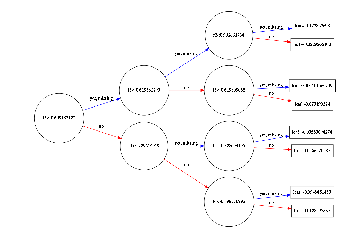

In [377]:
# plot single tree
#plot_tree(model)
#plot_tree(model, num_trees=4)
plot_tree(model, num_trees=4, rankdir='LR')
plt.show()

In [378]:
# make predictions for test data
y_pred = model.predict(X_test_sdt)
predictions = [value for value in y_pred]
print(confusion_matrix(y_test, y_pred))

[[255 139]
 [133 258]]


In [379]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.35%


In [380]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

# Manually Plot Feature Importance

[0.02360877 0.19224283 0.0910624  0.11973018 0.14671163 0.29679596
 0.12984823]


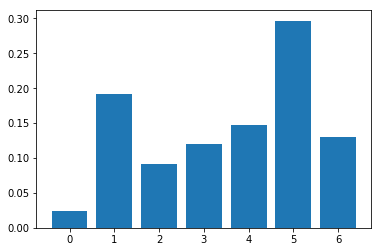

In [381]:
# feature importance
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

# Using theBuilt-in XGBoost Feature Importance Plot

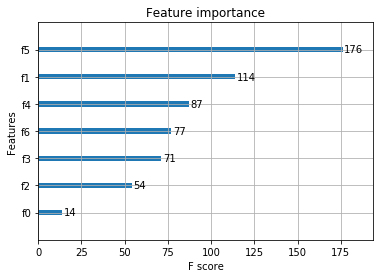

In [382]:
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
plt.show()

# Feature Selection with XGBoost Feature Importance Scores

In [47]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(nthread=-1,scale_pos_weight = 1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Evaluate XGBoost Models With k-Fold Cross Validation

In [58]:
# k-fold cross validation evaluation of xgboost model

# CV model
model = XGBClassifier(nthread=-1)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold, n_jobs=-1)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/sylvain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/b

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
# CV model
model = XGBClassifier(nthread=-1)
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold, n_jobs=-1)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))